In [2]:
import os
import sys

import pandas as pd
import numpy as np
import pickle
from datetime import date, datetime, timedelta
# sys.path.append(os.path.join(path[0], '..'))
# from utils import *

from category_encoders import OneHotEncoder
import xgboost as xgb

import boto3
import logging 

from IPython.display import display, HTML
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)
from IPython.display import display, HTML
import plotly.io as pio

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

from io import StringIO
class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model
    
def get_plot(df_in, grpby, x_var, y_var, title):
    
    data=[]
    for grp in df_in[grpby].unique().tolist():
        df_plt= df_in[df_in[grpby]==grp]
        data = data + [go.Scatter(x=df_plt[x_var], y=df_plt[y_var], mode='lines', name=grp)]  

    ## Initiate offline plot and create plot
    py.offline.init_notebook_mode(connected=True) 
    layout = dict(title = title, xaxis = dict(title = x_var), yaxis = dict(title = title),
                  autosize=False,  width= 600, height= 400, showlegend=True)
    
    fig = dict(data=data, layout=layout)
    py.offline.iplot(fig)
    return fig
    
    
input_bucket="hbo-ingest-datascience-content-dev"
key_path='psi_first_views/dev'


INFO:root:Starting Notebook


In [3]:
def munge_data(df_in):
    df_in['effective_start_date'] = pd.to_datetime(df_in['effective_start_date'])
    df_in['request_date'] = pd.to_datetime(df_in['request_date'])
    return df_in


def filter_data(df_in, date_train):
    date_train = pd.to_datetime(date_train) 
    df_in['train_date'] = date_train
    df_in = df_in[(df_in.effective_start_date < (date_train + timedelta(days=-4)))]  
    return df_in


def aggregate_data(df_in, grpby):
    df_in = df_in.groupby(by=grpby).sum().reset_index()
    return df_in


list_date_train = ['2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01']
grpby = ['title_name','season_number','category','tier','content_category','effective_start_date', 'train_date', 'request_date', 'days_since_premiere']

df_actual = Utils.read_csv_s3(input_bucket, key_path, f'fv_train_2022-02-09.csv')
df_actual = df_actual.rename(columns={'first_views':'first_views_actual'})
df_actual = munge_data(df_actual)

## Load extrapolation and actual 
list_title=[]

for date_train in list_date_train:
    ## Get actual
    df_actual_sub = filter_data(df_actual, date_train)
    df_title_actual = aggregate_data(df_actual_sub, grpby)

    ## Get extrapolation
    df_ext = Utils.read_csv_s3(input_bucket, key_path, f'fv_ext_{date_train}.csv')
    df_ext = munge_data(df_ext)
    df_ext = filter_data(df_ext, date_train)
    df_ext = df_ext[df_ext.finished_window_flag==0]
    df_title_ext = aggregate_data(df_ext, grpby)
    df_title_ext['days_since_premiere_eval'] = date_train = pd.to_datetime(date_train)  - df_title_ext['effective_start_date']
    
    df_title_day = df_title_ext.merge(df_title_actual[grpby + ['first_views_actual']], on=grpby, how='left')
    
    list_title.append(df_title_day)
    
df_title_day = pd.concat(list_title)
df_title_day['days_since_premiere_eval'] = df_title_day['days_since_premiere_eval'].dt.days.astype('int')

## Roll up to title 
df_title = df_title_day.groupby(by=grpby[:-2]).agg({'days_since_premiere_eval':'min',
                                                   'predicted_first_views':'sum', 'first_views_actual':'sum'}).reset_index()

labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
weeks = [i * 7 for i in labels]
df_title['weeks_since_premiere'] = pd.cut(df_title['days_since_premiere_eval'], bins=weeks, labels=labels[:-1])
df_title['mae']= ((df_title['first_views_actual']-df_title['predicted_first_views'])/(df_title['first_views_actual'])).abs()


INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_train_2022-02-09.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_ext_2021-08-01.csv
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_ext_2021-09-01.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_ext_2021-10-01.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_ext_2021-11-01.csv
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_ext_2021-12-01.csv


## Descriptive

In [13]:
for date in ['2021-10-01']:
    date = pd.to_datetime(date) 
    df = df_actual[(df_actual.request_date>=date) & (df_actual.request_date < (date + timedelta(days=90)))]
    df['flag'] = 'post'
    df.loc[df.effective_start_date<=date, 'flag'] = 'pre'  
    
df.groupby(by='flag').sum()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,season_number,tier,premiere_ind,asset_premiere_count,premiering_hours_runtime,first_views_actual,days_since_premiere,days_on_platform,finished_window_flag
flag,,,,,,,,,,
post,61941835,5840,6392,60,243,155.221,2299532,67371,238423,1526
pre,34788282,1313,5085,1,31,18.028,441142,113106,306291,1912


In [24]:
df_title.columns

Index(['title_name', 'season_number', 'category', 'tier', 'content_category',
       'effective_start_date', 'train_date', 'days_since_premiere_eval',
       'predicted_first_views', 'first_views_actual', 'weeks_since_premiere',
       'mae'],
      dtype='object')

## Monthly

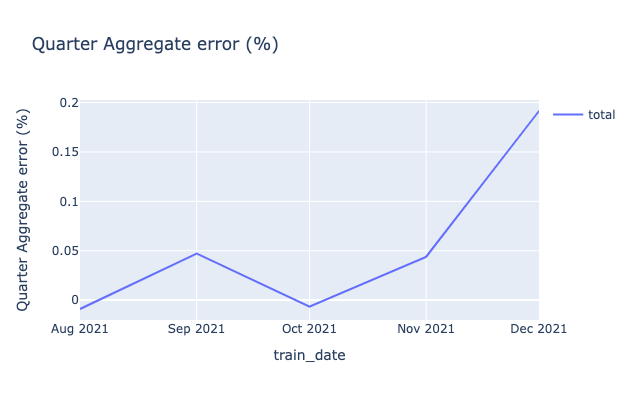

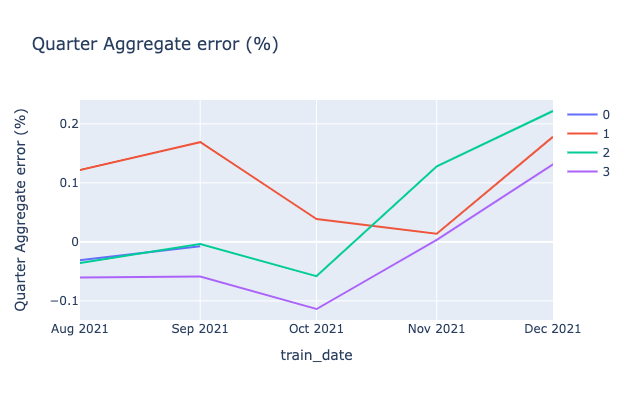

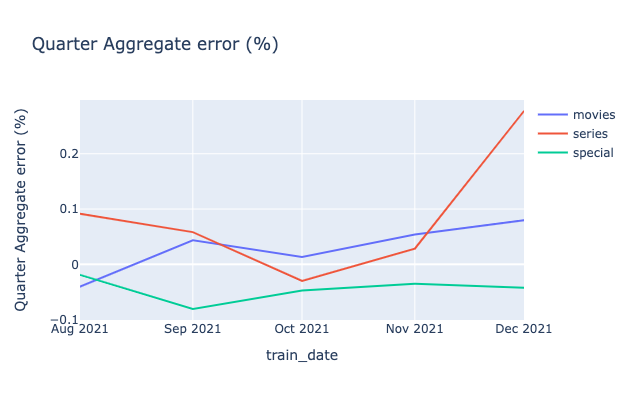

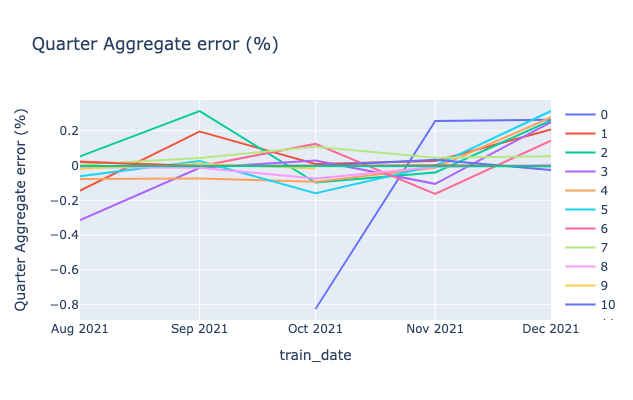

In [5]:
## Monthly error rate
grpby_stat=['train_date']
df_grp = df_title.groupby(by=grpby_stat).sum().reset_index()
df_grp['label'] = 'total'
df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual']))
fig = get_plot(df_grp, 'label', 'train_date', 'pe', 'Quarter Aggregate error (%)')

grpby_stat=['tier','train_date']
df_grp = df_title.groupby(by=grpby_stat).sum().reset_index()
df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual']))
fig = get_plot(df_grp, 'tier', 'train_date', 'pe', 'Quarter Aggregate error (%)')

grpby_stat=['content_category','train_date']
df_grp = df_title.groupby(by=grpby_stat).sum().reset_index()
df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual']))
fig = get_plot(df_grp, 'content_category', 'train_date', 'pe', 'Quarter Aggregate error (%)')


grpby_stat=['weeks_since_premiere','train_date']
df_grp = df_title.groupby(by=grpby_stat).sum().reset_index()
df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual']))
fig = get_plot(df_grp, 'weeks_since_premiere', 'train_date', 'pe', 'Quarter Aggregate error (%)')


## Post-launch week

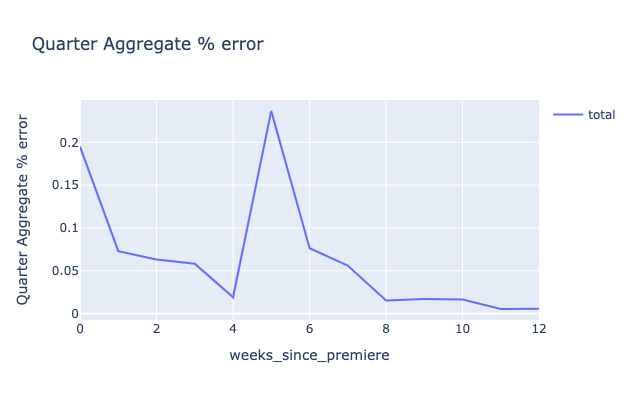

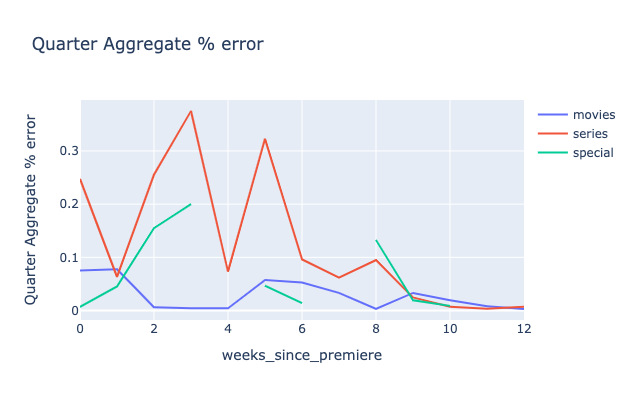

In [9]:
grpby_stat = ['label', 'weeks_since_premiere']
df_title['label'] = 'total'
df_grp = df_title.groupby(by=grpby_stat).sum().reset_index()
df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual'])).abs()
df_grp

fig = get_plot(df_grp, 'label', 'weeks_since_premiere', 'pe', 'Quarter Aggregate % error')



grpby_stat = ['content_category', 'weeks_since_premiere']
df_grp = df_title.groupby(by=grpby_stat).sum().reset_index()
df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual'])).abs()
df_grp

fig = get_plot(df_grp, 'content_category', 'weeks_since_premiere', 'pe', 'Quarter Aggregate % error')


## By data slice

In [66]:
grpby_list = [['train_date'], 
              ['weeks_since_premiere'],
              ['content_category'],
              ['category']
             ]

for grpby_stat in grpby_list:
    df_grp = df_title.groupby(by=grpby_stat).sum()
    df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual']))
    display(df_grp)


,season_number,tier,days_since_premiere_eval,predicted_first_views,first_views_actual,mae,pe
train_date,,,,,,,
2021-08-01,41,110,1949,2351395.0,2330335,6.795099,-0.009037
2021-09-01,36,122,2223,1377044.0,1444925,5.780714,0.046979
2021-10-01,27,102,2178,1123758.0,1116215,4.216754,-0.006758
2021-11-01,47,104,1779,1575425.0,1647334,5.013666,0.043652
2021-12-01,106,124,1879,891609.0,1102759,7.975873,0.191474


,season_number,tier,days_since_premiere_eval,predicted_first_views,first_views_actual,mae,pe
weeks_since_premiere,,,,,,,
0,19,20,53,273840.0,340187,2.466411,0.195031
1,9,55,272,1208716.0,1303688,5.274589,0.072849
2,74,48,398,1219316.0,1301717,7.158038,0.063302
3,12,44,431,861930.0,814458,3.496534,-0.058287
4,17,55,651,421768.0,413907,3.566319,-0.018992
5,19,40,584,278654.0,365017,1.866240,0.236600
6,20,45,871,445497.0,482337,1.999498,0.076378
7,20,44,894,426371.0,451741,1.428214,0.056160
8,10,52,1090,155864.0,153529,1.301421,-0.015209


,season_number,tier,days_since_premiere_eval,predicted_first_views,first_views_actual,mae,pe
content_category,,,,,,,
movies,0,206,3809,4006921.0,4106431,6.876212,0.024233
series,257,299,5440,2363864.0,2606343,21.526826,0.093034
special,0,57,759,948446.0,928794,1.379067,-0.021159


,season_number,tier,days_since_premiere_eval,predicted_first_views,first_views_actual,mae,pe
category,,,,,,,
Docu-Series,26,76,1184,223168.0,207618,4.761757,-0.074897
Documentary Features,1,60,849,53173.0,56353,1.276102,0.056430
International,32,69,1185,38543.0,37675,3.563207,-0.023039
Kids & Family,83,59,1123,44275.0,36284,5.573603,-0.220235
Pay1,0,122,2490,1329383.0,1369447,4.479898,0.029256
Popcorn,0,6,144,2472569.0,2512997,0.477181,0.016088
Scripted Comedy Series,47,32,578,496156.0,687294,2.859538,0.278102
Scripted Drama Series,36,24,802,1427498.0,1491154,3.224610,0.042689
Scripted Features,0,9,163,146670.0,163567,0.371287,0.103303


In [55]:
grpby_list = [['content_category', 'train_date', ], 
              ['content_category', 'weeks_since_premiere']]

for grpby_stat in grpby_list:
    df_grp = df_title.groupby(by=grpby_stat).sum()
    df_grp['pe'] = ((df_grp['first_views_actual']-df_grp['predicted_first_views'])/(df_grp['first_views_actual']))
    display(df_grp)


season_number  tier  days_since_premiere_eval  \
content_category train_date                                                  
movies           2021-08-01              0    43                       794   
                 2021-09-01              0    49                       965   
                 2021-10-01              0    37                       773   
                 2021-11-01              0    37                       670   
                 2021-12-01              0    40                       607   
series           2021-08-01             41    64                      1082   
                 2021-09-01             36    64                      1180   
                 2021-10-01             27    53                      1229   
                 2021-11-01             47    52                       882   
                 2021-12-01            106    66                      1067   
special          2021-08-01              0     3                        73   
                 2021-09-01              0     9                        78   
                 2021-10-01              0    12                       176   
                 2021-11-01              0    15                       227   
                 2021-12-01              0    18                       205   

                             predicted_first_views  first_views_actual  \
content_category train_date                                              
movies           2021-08-01              1088043.0             1045746   
                 2021-09-01               924297.0              966146   
                 2021-10-01               599144.0              607183   
                 2021-11-01               972938.0             1028337   
                 2021-12-01               422499.0              459019   
series           2021-08-01               376759.0              414673   
                 2021-09-01               438282.0              465396   
                 2021-10-01               507602.0              492791   
                 2021-11-01               584786.0              601901   
                 2021-12-01               456435.0              631582   
special          2021-08-01               886593.0              869916   
                 2021-09-01                14465.0               13383   
                 2021-10-01                17012.0               16241   
                 2021-11-01                17701.0               17096   
                 2021-12-01                12675.0               12158   

                                  mae        pe  
content_category train_date                      
movies           2021-08-01  1.275055 -0.040447  
                 2021-09-01  1.805616  0.043315  
                 2021-10-01  1.537655  0.013240  
                 2021-11-01  0.839664  0.053872  
                 2021-12-01  1.418222  0.079561  
series           2021-08-01  5.493953  0.091431  
                 2021-09-01  3.600129  0.058260  
                 2021-10-01  2.438576 -0.030055  
                 2021-11-01  3.911089  0.028435  
                 2021-12-01  6.083079  0.277315  
special          2021-08-01  0.026091 -0.019171  
                 2021-09-01  0.374969 -0.080849  
                 2021-10-01  0.240523 -0.047472  
                 2021-11-01  0.262913 -0.035388  
                 2021-12-01  0.474571 -0.042523

season_number  tier  \
content_category weeks_since_premiere                        
movies           0                               0.0   7.0   
                 1                               0.0  23.0   
                 2                               0.0  13.0   
                 3                               0.0  19.0   
                 4                               0.0  18.0   
                 5                               0.0  18.0   
                 6                               0.0  16.0   
                 7                               0.0  14.0   
                 8                               0.0  25.0   
                 9                               0.0  11.0   
                 10                              0.0  22.0   
                 11                              0.0   6.0   
                 12                              0.0  14.0   
series           0                              19.0  10.0   
                 1                               9.0  17.0   
                 2                              74.0  32.0   
                 3                              12.0  19.0   
                 4                              17.0  37.0   
                 5                              19.0  13.0   
                 6                              20.0  23.0   
                 7                              20.0  30.0   
                 8                              10.0  24.0   
                 9                              15.0  25.0   
                 10                             15.0  21.0   
                 11                             15.0  26.0   
                 12                             12.0  22.0   
special          0                               0.0   3.0   
                 1                               0.0  15.0   
                 2                               0.0   3.0   
                 3                               0.0   6.0   
                 4                               NaN   NaN   
                 5                               0.0   9.0   
                 6                               0.0   6.0   
                 7                               NaN   NaN   
                 8                               0.0   3.0   
                 9                               0.0   6.0   
                 10                              0.0   3.0   
                 11                              NaN   NaN   
                 12                              0.0   3.0   

                                       days_since_premiere_eval  \
content_category weeks_since_premiere                             
movies           0                                         19.0   
                 1                                        136.0   
                 2                                        122.0   
                 3                                        198.0   
                 4                                        225.0   
                 5                                        277.0   
                 6                                        315.0   
                 7                                        269.0   
                 8                                        547.0   
                 9                                        267.0   
                 10                                       674.0   
                 11                                       325.0   
                 12                                       435.0   
series           0                                         27.0   
                 1                                         84.0   
                 2                                        258.0   
                 3                                        179.0   
                 4                                        426.0   
                 5                                        192.0   
                 6                                        465.0   
                 7    

## Title level

In [31]:
df_title_raw = df_title.copy()
df_title = df_title[df_title.first_views_actual>2000]

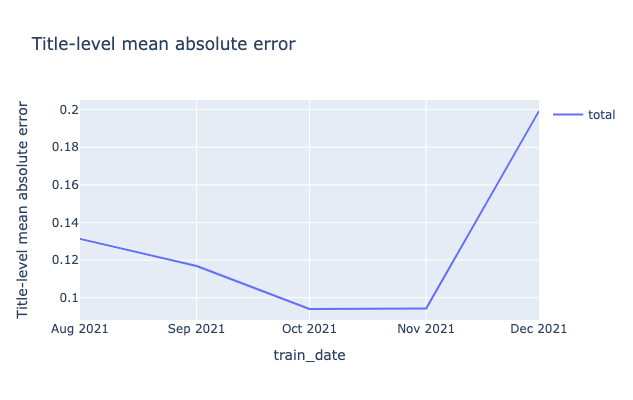

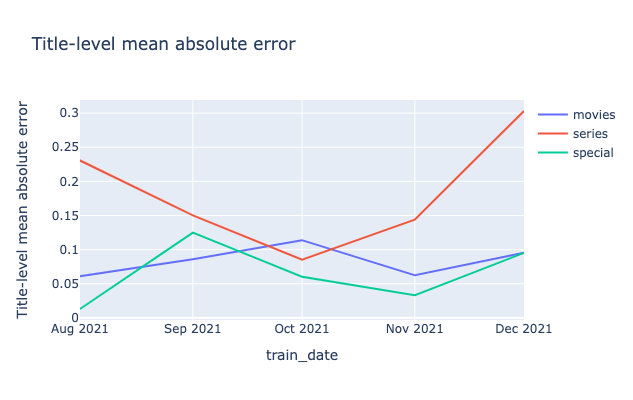

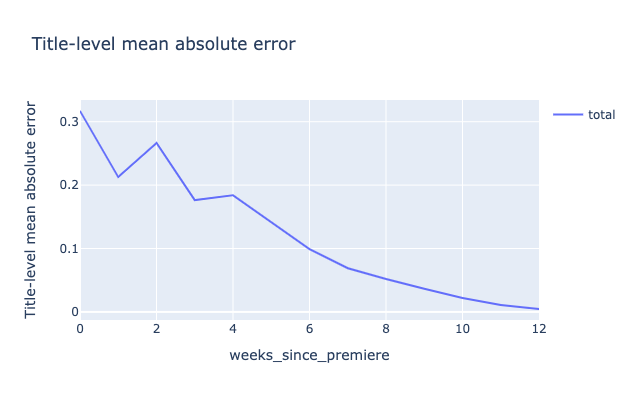

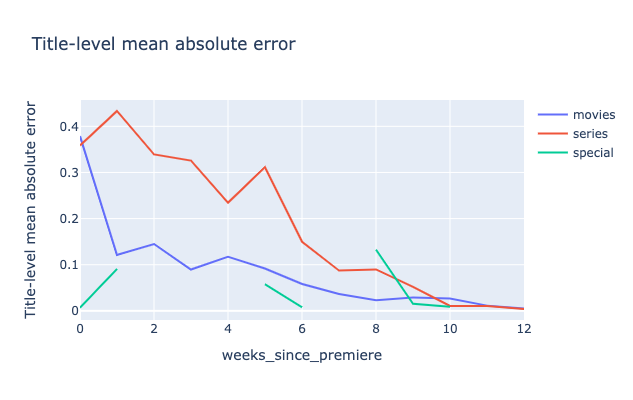

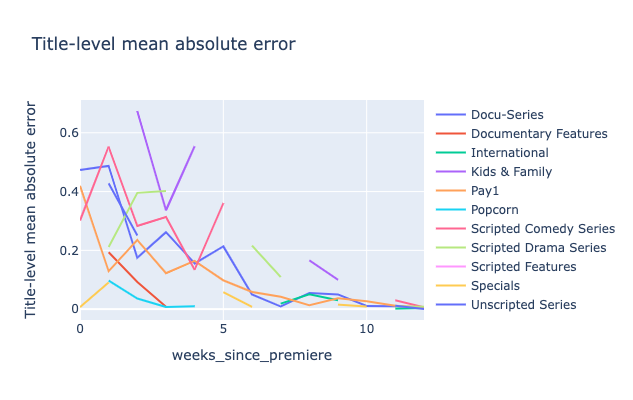

In [32]:
## Monthly error rate
grpby_list = [['label', 'train_date',],
                ['content_category', 'train_date',], 
              ['label', 'weeks_since_premiere'],
              ['content_category', 'weeks_since_premiere'],
              ['category','weeks_since_premiere']
             ]

df_title['label']='total'
for grpby_stat in grpby_list:
    df_grp = df_title.groupby(by=grpby_stat).mean().reset_index()
    fig = get_plot(df_grp, grpby_stat[0], grpby_stat[1], 'mae', 'Title-level mean absolute error')
